# Week 6 Convolution and Fourier Transforms

### Date: 16th Nov 2023

In the last lecture you learned about linear image filtering operations like correlation and
convolution and how these can be applied directly on the image or the Fourier transform of
the image.
These kind of filtering operations have many uses, ranging from smoothing and noise
reduction, to feature enhancement and sharpening, calculating image derivatives, edge
detection and even template matching.
Your task today is to code your own linear filtering functions operating on the image domain
and to study the Fourier transform.

In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
# to visualize the plots within the notebook
%matplotlib inline

## Task 1: Convolution (space domain)
Convolution is a fundamental operation for applying linear filters to images. It takes as input
an image (greyscale) I and a filter kernel K and returns the result I’ of convolving the image
with this filter.

Definition: Given a greyscale image I and a filter K of size (2N + 1) x (2M + 1) (we use odd
dimension filters like 3 x 3, 5 x 5 etc.), convolution is defined as:

\begin{equation}
I'(x, y) = \sum_{i=-a}^a \sum_{j=-b}^b K(i, j) I(x - i, y - j)
\end{equation}

Your task is to write your own convolution function (do not use the conv2() function) and test
it with different filters. How will you handle the behaviour of the filter in the edges of the
image (pad with zeros, copy the edge etc.)?

Smoothing filters that reduce noise in images are quite useful in image processing. Use a
simple mean filter like:

\begin{equation}
\begin{bmatrix}1 & 1 & 1\\1 & 1 & 1\\1 & 1 & 1
\end{bmatrix}
\end{equation}

This filter replaces each pixel by the average of its neighbourhood. Now if we want
something better, we can try weighing the contributions of the neighbouring pixels by their
proximity to the centre pixel. Try a Gaussian filter, which is defined as: 

\begin{equation}
G_{\sigma} = \frac{1}{2\pi \sigma^2} e^{-\frac{(x^2 + y^2)}{2 \sigma^2}}
\end{equation}

where $\sigma$ is the standard deviationof the Gaussian. This is a continuous function, so your filter will need to sample it in both x and y directions (use np.meshgrid()), keeping in mind the value for $\sigma$ that you chose. Try different filter sizes and different values for $\sigma$ and compare the results. Here is the results obtained using opencv built-in functions. If your implementation is correct, you should expect to have similar results.

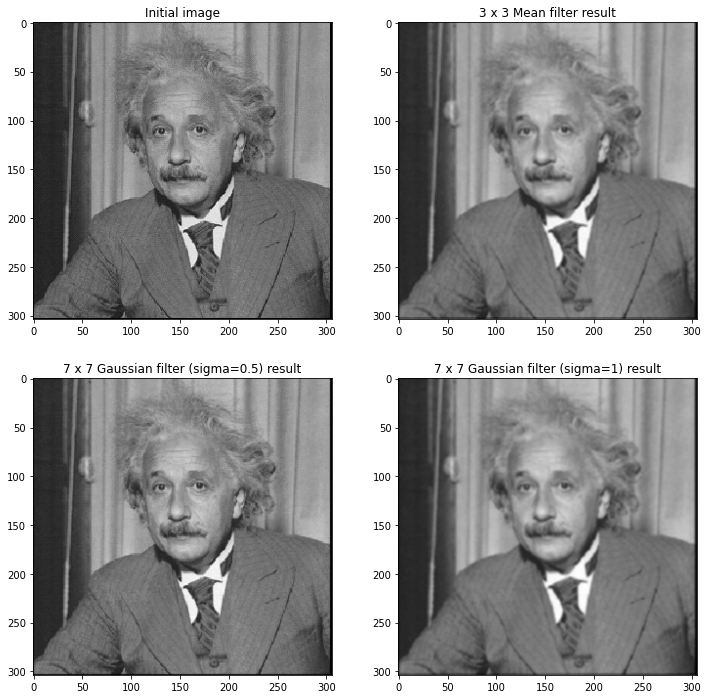

In [2]:
img = cv2.imread("../images/einstein.png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
mean_blur = cv2.blur(img_gray, (3, 3))  # mean filter 3x3
gaussian_1 = cv2.GaussianBlur(img_gray, (7, 7), 0.5, 0.5)  # gaussian filter 7x7, sigma = 0.5
gaussian_2 = cv2.GaussianBlur(img_gray, (7, 7), 1., 1.)  # gaussian filter 7x7, sigma = 1.0
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot(2, 2, 1)
ax1.title.set_text("Initial image")
plt.imshow(img_gray, "gray")
ax2 = plt.subplot(2, 2, 2)
ax2.title.set_text("3 x 3 Mean filter result")
plt.imshow(mean_blur, "gray")
ax3 = plt.subplot(2, 2, 3)
ax3.title.set_text("7 x 7 Gaussian filter (sigma=0.5) result")
plt.imshow(gaussian_1, "gray")
ax4 = plt.subplot(2, 2, 4)
ax4.title.set_text("7 x 7 Gaussian filter (sigma=1) result")
plt.imshow(gaussian_2, "gray")
plt.show()

### Implement your own code here:

hint: You can use `cv2.copyMakeBorder` to do paddings to the image. Figure out how to use it by yourself!

In [44]:
"""
Implement your code here
"""
def apply_filter(src_img, kernel):
    '''
    Impelemnt filtering algorithm
    :param src_img: gray scaled source image with size HxW
    :param kernel: kernel to be applied to the source image
    :return rst_img: filtered image
    '''
    assert len(src_img.shape) == 2, print("Dimension mismatch! Please supply gray-scale image only!")
    assert len(kernel.shape) == 2, print("Dimension mismatch! Please supply 2D kernel only!")
    h, w = kernel.shape
    # using vectorized solution
    window_shape = (h,w)
    denoised_image = np.zeros((src_img.shape[0], src_img.shape[1]))

    img = src_img
    # padding
    img = np.pad(img, ((int((h-1)/2),), (int((w-1)/2),)), 'edge')

    axis = tuple(range(img.ndim))
    out_strides = img.strides + tuple(img.strides[ax] for ax in axis)
    x_shape_trimmed = list(img.shape)
    for ax, dim in zip(axis, window_shape):
        x_shape_trimmed[ax] -= dim - 1
    out_shape = tuple(x_shape_trimmed) + window_shape
    wow =  np.lib.stride_tricks.as_strided(img, strides=out_strides, shape=out_shape, writeable=False)
    
    denoised_image = np.einsum('ij,abij->ab',kernel,wow)
    return denoised_image.astype(int)
    
def get_mean_filter_kernel(h, w):
    '''
    Get kernel of mean filter
    '''
    assert (h % 2 == 1) and (w % 2 == 1), print("kernal size must be odd number!")
    out_kernel = np.ones((h, w))/(h*w)

    return out_kernel

def get_gaussian_kernel(h, w, sigma):
    '''
    Get kernel of Gaussian filter
    '''
    assert (h % 2 == 1) and (w % 2 == 1), print("kernal size must be odd number!")
    y, x = np.ogrid[-h:h+1, -w:w+1]
    grid = x**2 + y**2
    out_kernel = np.exp(-0.5*grid/sigma**2)
    out_kernel = out_kernel / np.sum(out_kernel)

    return out_kernel

In [9]:
"""
Get kernels and apply filter here
"""
k_mean = get_mean_filter_kernel(3, 3)
G1 = get_gaussian_kernel(7, 7, 0.5)
G2 = get_gaussian_kernel(7, 7, 1.)
img_mean_blur = apply_filter(img_gray, k_mean)
img_gaussian_1 = apply_filter(img_gray, G1)
img_gaussian_2 = apply_filter(img_gray, G2)

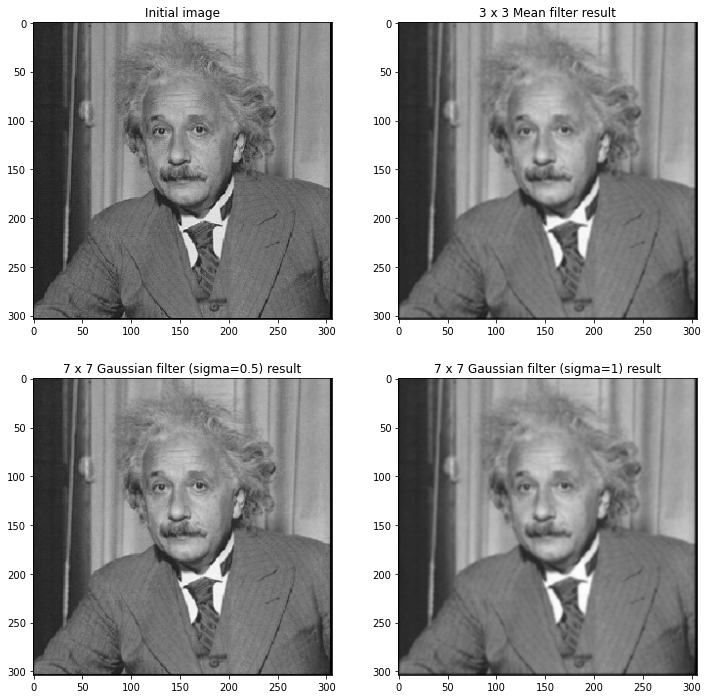

In [10]:
"""
Plot the results
"""
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot(2, 2, 1)
ax1.title.set_text("Initial image")
plt.imshow(img_gray, "gray")
ax2 = plt.subplot(2, 2, 2)
ax2.title.set_text("3 x 3 Mean filter result")
plt.imshow(img_mean_blur, "gray")
ax3 = plt.subplot(2, 2, 3)
ax3.title.set_text("7 x 7 Gaussian filter (sigma=0.5) result")
plt.imshow(img_gaussian_1, "gray")
ax4 = plt.subplot(2, 2, 4)
ax4.title.set_text("7 x 7 Gaussian filter (sigma=1) result")
plt.imshow(img_gaussian_2, "gray")

## Task 2: Fourier Transform

The second task for today is related to Fourier transforms. As you have learned in class, the
Fourier transform is a very useful way to do image filtering and other image operations. In
this task, you will study the magnitude and phase of the Fourier transform. The task is
simple, you just need to follow these steps:

1. Load two greyscale images
2. Convert them to the Fourier domain (use `np.fft.fft2()`)
3. Plot the magnitude and phase of the two Fourier transforms (use `np.abs()` and `np.angle()`)
4. Now try switching the phase between the two Fourier transforms and reconstruct the original images. If you have the magnitude, say $|C|$ and the phase, say $\theta$, of the Fourier complex numbers, you can use this formula to convert back to the original complex numbers. So you can replace the phase of one image with the phase of the other image, and then invert the Fourier transform to see the result (use `np.fft.ifft2()`).

\begin{equation}
C = |C|(cos\theta + j \sin\theta)
\end{equation}

Notes:
1. numpy's fft2 computes the 2-D Fourier transform of the image, where the zero-frequency component is not in the center as shown in the result, but rather in the top-left corner. In order to have the same results, a shift operation is required. (Note: this is only required for displaying the result. You don't need this to do the reconstruction). You can use fftshift function shifts the zero-frequency component to the center of the output.

2. When displaying the magnitude, the range of values is NOT between [0,1] as expected by plt, but instead much larger. The solution is to display the log value of the magnitude.

In [11]:
img_zebra = cv2.imread("../images/zebra.png")
img_cheetah = cv2.imread("../images/cheetah.png")
img_zebra_gray = cv2.cvtColor(img_zebra, cv2.COLOR_BGR2GRAY).astype(np.float32)
img_cheetah_gray = cv2.cvtColor(img_cheetah, cv2.COLOR_BGR2GRAY).astype(np.float32)

In [39]:
"""
Implement your code here
"""
# Get fft of zebra
fft_zebra = np.fft.fft2((img_zebra_gray))
zebra_mag = np.abs(fft_zebra)
zebra_phase = np.angle(fft_zebra)
# Get fft of cheetah
fft_cheetah = np.fft.fft2(img_cheetah_gray)
cheetah_mag = np.abs(fft_cheetah)
cheetah_phase = np.angle(fft_cheetah)
# switch magnitude and phase
fft_cheetah_zebra = cheetah_mag*(np.cos(zebra_phase) + 1j*np.sin(zebra_phase))
fft_zebra_cheetah = zebra_mag*(np.cos(cheetah_phase) + 1j*np.sin(cheetah_phase))
img_cheetah_zebra = np.abs(np.fft.ifft2(fft_cheetah_zebra))
img_zebra_cheetah = np.abs(np.fft.ifft2(fft_zebra_cheetah))

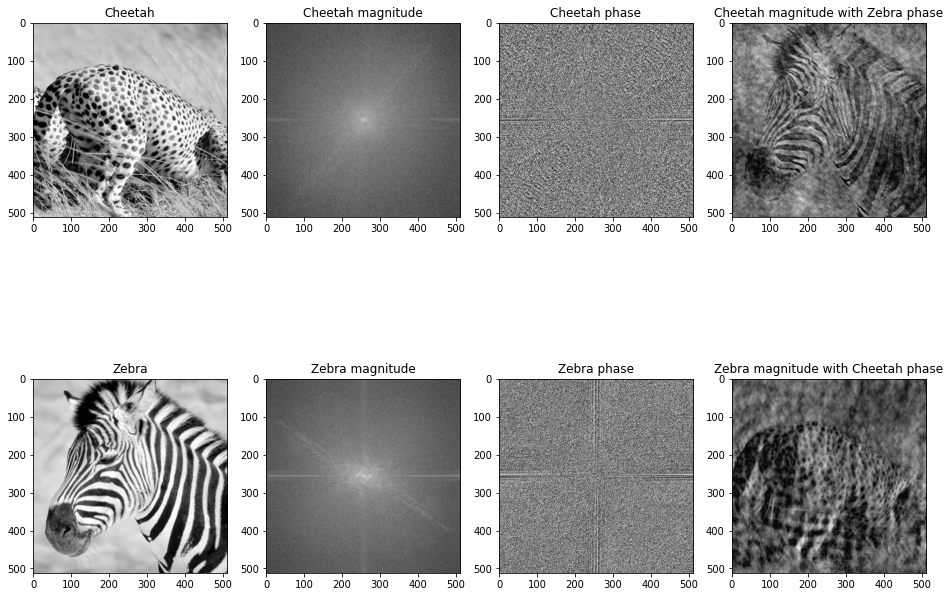

In [40]:
"""
Plot the results
"""
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot(2, 4, 1)
ax1.title.set_text("Cheetah")
plt.imshow(img_cheetah, "gray")
ax2 = plt.subplot(2, 4, 2)
ax2.title.set_text("Cheetah magnitude")
plt.imshow(np.log(np.fft.fftshift(cheetah_mag)), "gray")
ax3 = plt.subplot(2, 4, 3)
ax3.title.set_text("Cheetah phase")
plt.imshow(np.fft.fftshift(cheetah_phase), "gray")
ax4 = plt.subplot(2, 4, 4)
ax4.title.set_text("Cheetah magnitude with Zebra phase")
plt.imshow(img_cheetah_zebra, "gray")
ax5 = plt.subplot(2, 4, 5)
ax5.title.set_text("Zebra")
plt.imshow(img_zebra, "gray")
ax6 = plt.subplot(2, 4, 6)
ax6.title.set_text("Zebra magnitude")
plt.imshow(np.log(np.fft.fftshift(zebra_mag)), "gray")
ax7 = plt.subplot(2, 4, 7)
ax7.title.set_text("Zebra phase")
plt.imshow(np.fft.fftshift(zebra_phase), "gray")
ax8 = plt.subplot(2, 4, 8)
ax8.title.set_text("Zebra magnitude with Cheetah phase")
plt.imshow(img_zebra_cheetah, "gray")

## Task 3: Convolution (frequency domain)

In task 1 you have implemented 2D convolution in space domain. In this task you are required to implement it in frequency domain using Fourier Transform. 

Hint: Look up for `np.fft.fft2`, `np.fft.ifft2` `np.fft.ifftshift`

In [286]:
"""
Implement your code here
"""
def apply_filter_fft(src_img, kernel):
    assert len(src_img.shape) == 2, print("Dimension mismatch! Please supply gray-scale image only!")
    assert len(kernel.shape) == 2, print("Dimension mismatch! Please supply 2D kernel only!")
    kh, kw = kernel.shape
    H, W = src_img.shape
    x, y = (H-kh)//2, (W-kw)//2
    # kernel = np.pad(kernel, ((x, H-kh-x), (y, W-kw-y)), 'constant')
    fft_im = np.fft.fft2(src_img, src_img.shape)
    fft_k  = np.fft.fft2(kernel, src_img.shape)
    fft_out = fft_k * fft_im
    denoised_image = np.abs(np.fft.ifft2(fft_out))
    return np.roll(np.roll(denoised_image, -(kh-1)//2, axis=0), -(kw-1)//2, axis=1)

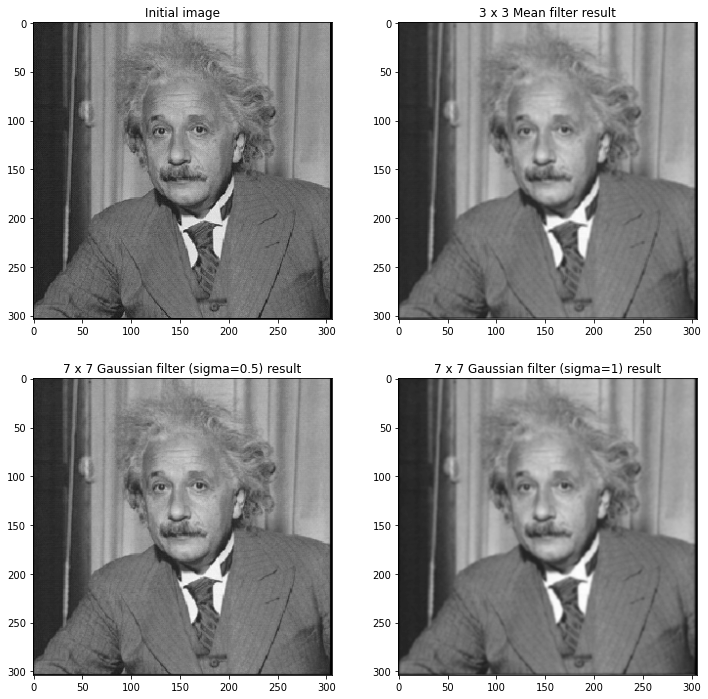

In [287]:
"""
Get kernels and apply filter here
"""
k_mean = get_mean_filter_kernel(3, 3)
G1 = get_gaussian_kernel(7, 7, 0.5)
G2 = get_gaussian_kernel(7, 7, 1.)
img_mean_blur_fft = apply_filter_fft(img_gray, k_mean)
img_gaussian_1_fft = apply_filter_fft(img_gray, G1)
img_gaussian_2_fft = apply_filter_fft(img_gray, G2)

"""
Plot the results
"""
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot(2, 2, 1)
ax1.title.set_text("Initial image")
plt.imshow(img_gray, "gray")
ax2 = plt.subplot(2, 2, 2)
ax2.title.set_text("3 x 3 Mean filter result")
plt.imshow(img_mean_blur_fft, "gray")
ax3 = plt.subplot(2, 2, 3)
ax3.title.set_text("7 x 7 Gaussian filter (sigma=0.5) result")
plt.imshow(img_gaussian_1_fft, "gray")
ax4 = plt.subplot(2, 2, 4)
ax4.title.set_text("7 x 7 Gaussian filter (sigma=1) result")
plt.imshow(img_gaussian_2_fft, "gray")
plt.show()